In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


from torchvision import datasets, transforms
from torch.utils.data import DataLoader



### Observe Gradient Norm During Training Use The Sinc Function

In [2]:
# Define the sinc function
def sinc_function(x):
    return torch.where(x == 0, torch.tensor(1.0), torch.sin(5 * torch.pi * x) / (5 * torch.pi * x))

# Prepare the dataset
x = torch.linspace(-1, 1, 400).unsqueeze(-1)  # unsqueeze to make it a 2D tensor
y = sinc_function(x)

# Define the model
class SincNN(nn.Module):
    def __init__(self):
        super(SincNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the model, optimizer, and loss function
model = SincNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Function
def train_model(model, x, y, optimizer, criterion, epochs):
    losses = []
    grad_norms = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        
        # Compute the p-norm of the gradients
        total_norm = torch.tensor(0.0)
        for p in model.parameters():
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm.sqrt()

        optimizer.step()

        losses.append(loss.item())
        grad_norms.append(total_norm.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Grad Norm: {total_norm.item()}')

    return losses, grad_norms

# Train the model
epochs = 2000
losses, grad_norms = train_model(model, x, y, optimizer, criterion, epochs)


Epoch 1/2000, Loss: 0.0891166478395462, Grad Norm: 0.07682052254676819
Epoch 101/2000, Loss: 0.07304874062538147, Grad Norm: 0.029574614018201828
Epoch 201/2000, Loss: 0.05799689143896103, Grad Norm: 0.026375237852334976
Epoch 301/2000, Loss: 0.04085623845458031, Grad Norm: 0.031045105308294296
Epoch 401/2000, Loss: 0.02300793118774891, Grad Norm: 0.029617121443152428
Epoch 501/2000, Loss: 0.01139209046959877, Grad Norm: 0.019715644419193268
Epoch 601/2000, Loss: 0.006538908462971449, Grad Norm: 0.01057879626750946
Epoch 701/2000, Loss: 0.004525994416326284, Grad Norm: 0.0063215442933142185
Epoch 801/2000, Loss: 0.003476071171462536, Grad Norm: 0.003735114121809602
Epoch 901/2000, Loss: 0.0030048531480133533, Grad Norm: 0.0023947448935359716
Epoch 1001/2000, Loss: 0.0027827247977256775, Grad Norm: 0.0016243478748947382
Epoch 1101/2000, Loss: 0.002672916976734996, Grad Norm: 0.0011872840113937855
Epoch 1201/2000, Loss: 0.002618572674691677, Grad Norm: 0.003644968383014202
Epoch 1301/200

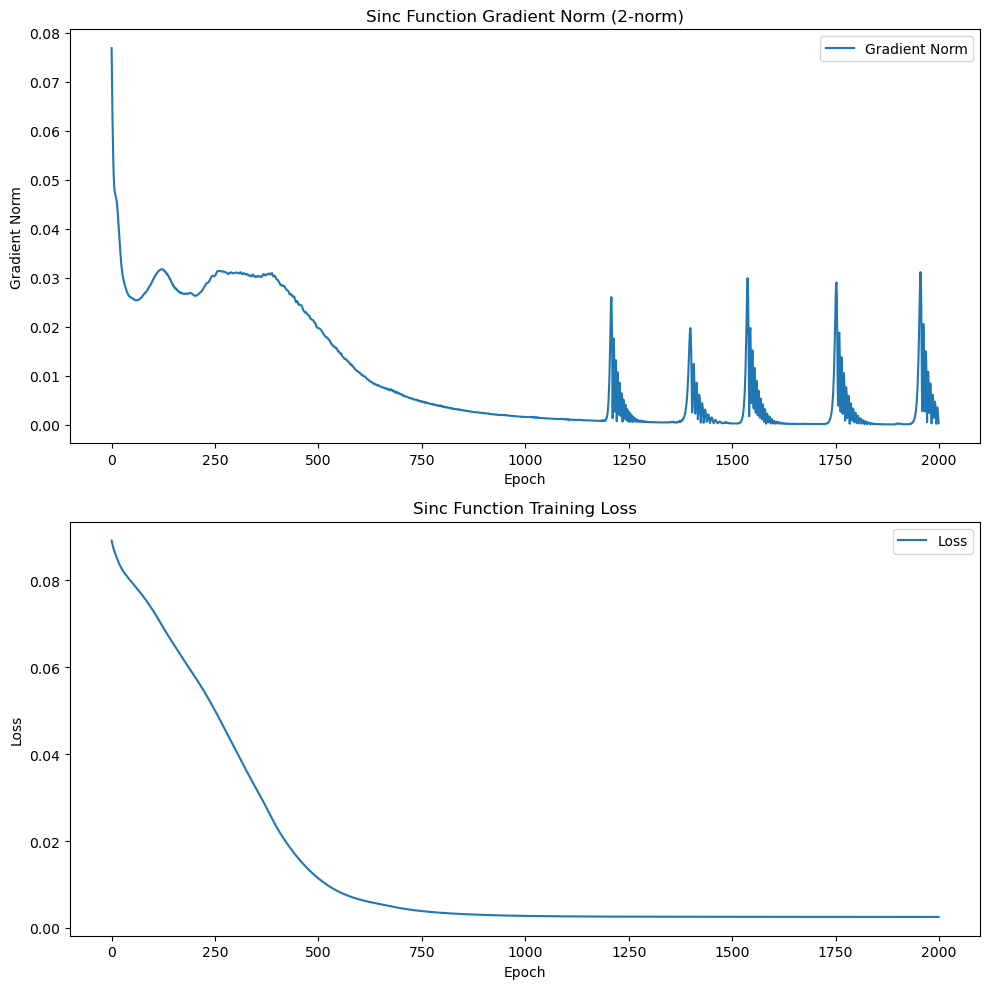

In [3]:
# Plot the gradient norms and loss on separate subplots, vertically aligned
plt.figure(figsize=(10, 10))

# Gradient Norm (2-norm) on top
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(grad_norms, label='Gradient Norm')
plt.title('Sinc Function Gradient Norm (2-norm)')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()

# Training Loss on the bottom
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(losses, label='Loss')
plt.title('Sinc Function Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust subplots to fit in the figure area
plt.show()


### Observe Gradient Norm During Training on MNIST

In [4]:
# Step 1: Load the MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Step 2: Define the DNN Model
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

# Initialize the model, optimizer, and loss function
model = DNNModel()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()



In [5]:
# Step 3: Training Function
def train_model(model, train_loader, optimizer, criterion, epochs):
    model.train()  # Set the model to training mode
    losses = []
    grad_norms = []

    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Compute the 2-norm of the gradients
            total_norm = 0.0
            for p in model.parameters():
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5

            optimizer.step()

            losses.append(loss.item())
            grad_norms.append(total_norm)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Grad Norm: {total_norm}')

    return losses, grad_norms

# Step 4: Train the model and plot the gradient norms and losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 5  # You can adjust the number of epochs
losses, grad_norms = train_model(model, train_loader, optimizer, criterion, epochs)



Epoch 1/5, Loss: 0.6260270476341248, Grad Norm: 2.956976653745439
Epoch 2/5, Loss: 0.00816507637500763, Grad Norm: 0.19988200407163567
Epoch 3/5, Loss: 0.3076380491256714, Grad Norm: 3.112033100919447
Epoch 4/5, Loss: 0.031219879165291786, Grad Norm: 0.8689599124146031
Epoch 5/5, Loss: 0.06401007622480392, Grad Norm: 1.5546588283850444


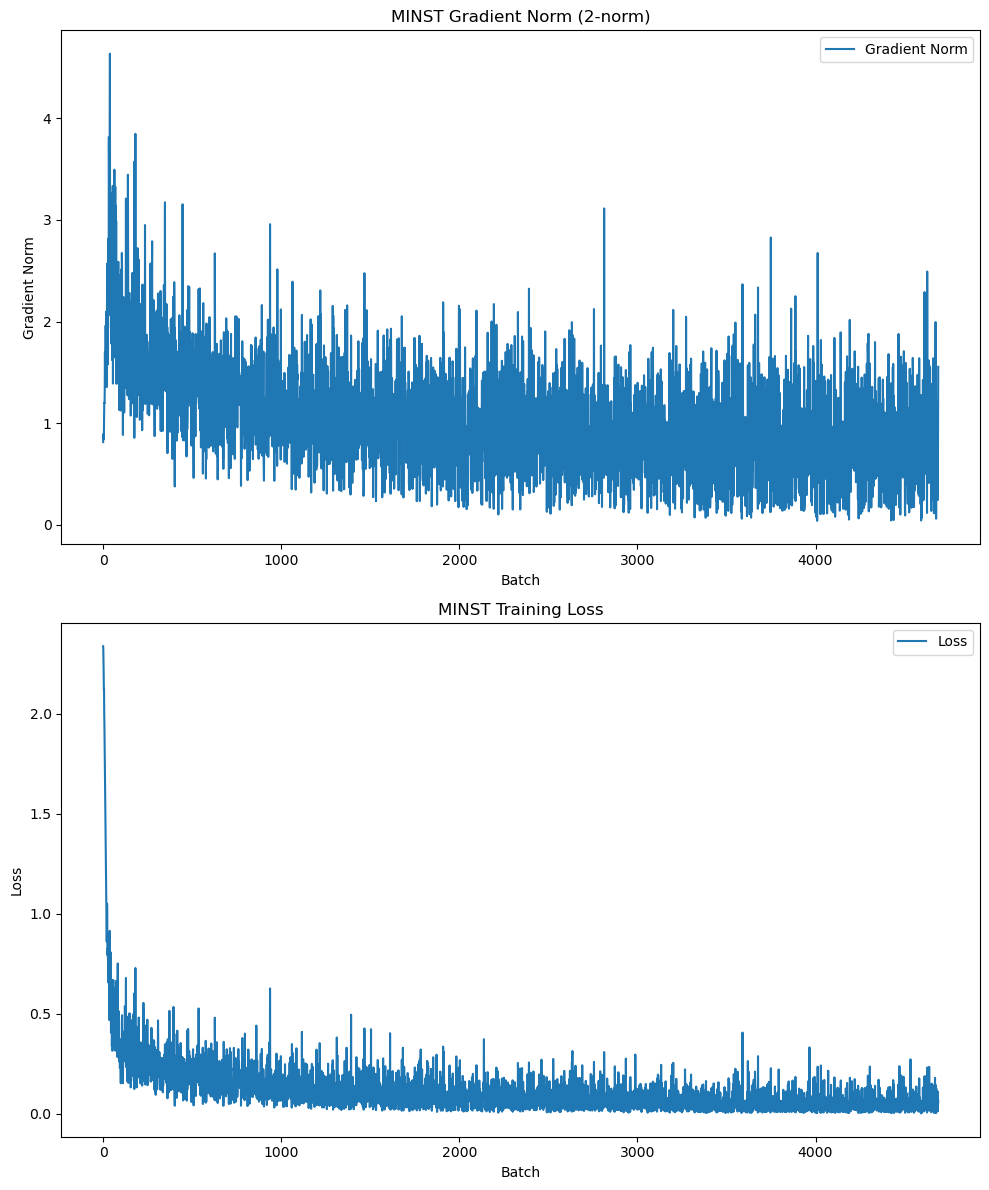

In [6]:
# Plot the gradient norms and losses
plt.figure(figsize=(10, 12))

# Gradient Norm (2-norm) on top
plt.subplot(2, 1, 1)
plt.plot(grad_norms, label='Gradient Norm')
plt.title('MINST Gradient Norm (2-norm)')
plt.xlabel('Batch')
plt.ylabel('Gradient Norm')
plt.legend()

# Training Loss on the bottom
plt.subplot(2, 1, 2)
plt.plot(losses, label='Loss')
plt.title('MINST Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
